# 二、小费分析 Tip Analysis


In [ ]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/7004-texi/nyc_taxi_part_1_with_coords.csv')
df_train.head()

,Unnamed: 0,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon
0,0,2,2024-01-03T19:42:57.000,2024-01-03T20:15:55.000,1.0,16.67,1.0,N,132,165,...,5.00,0.00,1.0,73.55,0.0,1.75,40.642948,-73.779373,40.618882,-73.965489
1,1,2,2024-01-03T18:43:26.000,2024-01-03T18:43:29.000,2.0,0.01,5.0,N,95,95,...,17.54,0.00,1.0,105.23,0.0,0.00,40.723101,-73.846613,40.723101,-73.846613
2,2,2,2024-01-03T17:00:52.000,2024-01-03T17:01:05.000,2.0,0.00,5.0,N,265,265,...,0.00,0.00,1.0,121.00,0.0,0.00,NaN,NaN,NaN,NaN
3,3,2,2024-01-03T10:00:04.000,2024-01-03T11:08:22.000,1.0,21.60,1.0,N,132,136,...,18.46,6.94,1.0,110.75,0.0,1.75,40.642948,-73.779373,40.872570,-73.902662
4,4,2,2024-01-01T00:01:58.000,2024-01-01T00:10:04.000,3.0,1.70,1.0,N,234,144,...,2.36,0.00,1.0,18.06,2.5,0.00,40.736072,-73.990189,40.722500,-73.994000


# (1) Basic Tipping Statistics

In [ ]:
payment_type_counts = df_train['payment_type'].value_counts()
print("Count of trips by Payment Type:")
print(payment_type_counts)

Count of trips by Payment Type:
payment_type
1    7772497
2    1533303
0     453183
4      80368
3      46184
Name: count, dtype: int64


# (2) Multi-dimensional correlation analysis

In [ ]:
df_train['tip_pct'] = df_train['tip_amount'] / df_train['fare_amount'].clip(lower=0.1)  # 避免除零
df_train['hour'] = pd.to_datetime(df_train['tpep_pickup_datetime']).dt.hour


## 1) Payment Type vs. tip amount

支付类型统计摘要:


total_amount                 tip_amount                  
                     mean median    count       mean median <lambda_0>
payment_type                                                          
0                28.79502  24.49   453183    1.99724   0.00    0.41338
1                30.30059  22.25  7772497    4.49794   3.36    0.95307
2                25.49953  18.20  1533303    0.00040   0.00    0.00007
3                21.98723  13.60    46184    0.09647   0.00    0.00435
4                25.65733  16.80    80368    0.02271   0.00    0.00143

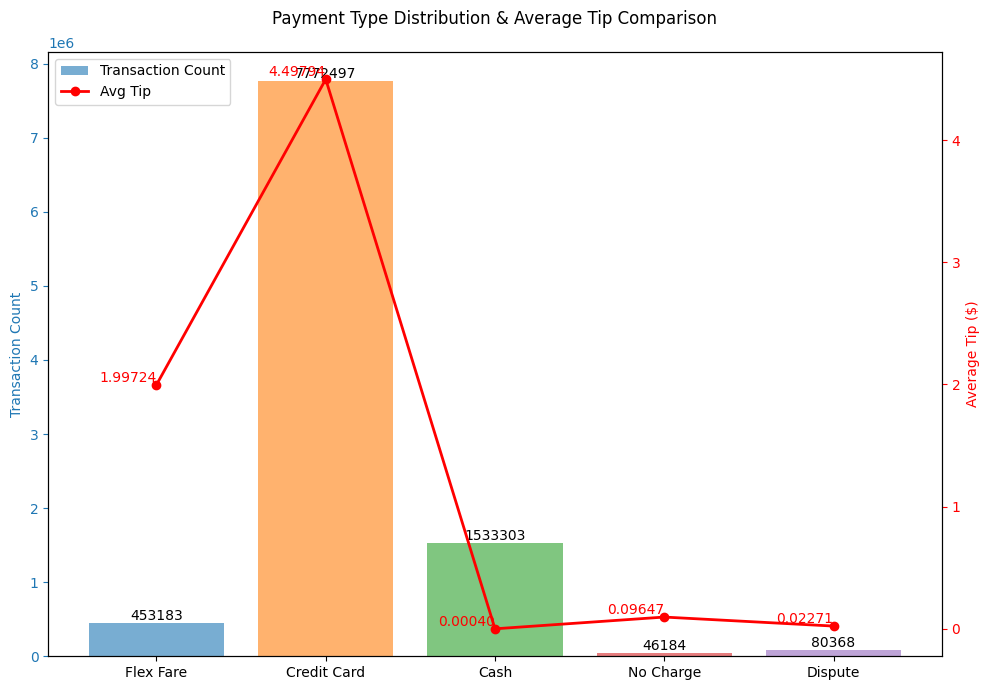

In [ ]:
# Number of payment types and average tip amount distribution
payment_stats = df_train.groupby(df_train['payment_type']).agg({
    'total_amount': ['mean', 'median', 'count'],
    'tip_amount': ['mean', 'median', lambda x: (x > 0).mean()]  # 小费支付率
}).round(5)

print("支付类型统计摘要:")
display(payment_stats)
# Display
fig, ax1 = plt.subplots(figsize=(10, 7)) # Increased figure size for potentially more space

color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
payment_counts = df_train['payment_type'].value_counts().sort_index()

bars = ax1.bar(payment_counts.index, payment_counts.values, color=color, alpha=0.6, label='Transaction Count')
ax1.set_ylabel('Transaction Count', color='#1f77b4')
ax1.tick_params(axis='y', colors='#1f77b4')
ax1.set_xticks([0, 1, 2, 3, 4])
ax1.set_xticklabels(['Flex Fare', 'Credit Card', 'Cash', 'No Charge', 'Dispute'])

for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 0), va='bottom', ha='center')

ax2 = ax1.twinx()
tip_means = df_train.groupby('payment_type')['tip_amount'].mean()
line = ax2.plot(tip_means.index, tip_means.values, color='red', marker='o', lw=2, label='Avg Tip')[0]
ax2.set_ylabel('Average Tip ($)', color='red')
ax2.tick_params(axis='y', colors='red')

for x, y in zip(tip_means.index, tip_means.values):
    ax2.text(x, y, f'{y:.5f}', va='bottom', ha='right', color='red')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Payment Type Distribution & Average Tip Comparison', pad=20)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 2) Travel distance vs. tip amount (2D Histogram)

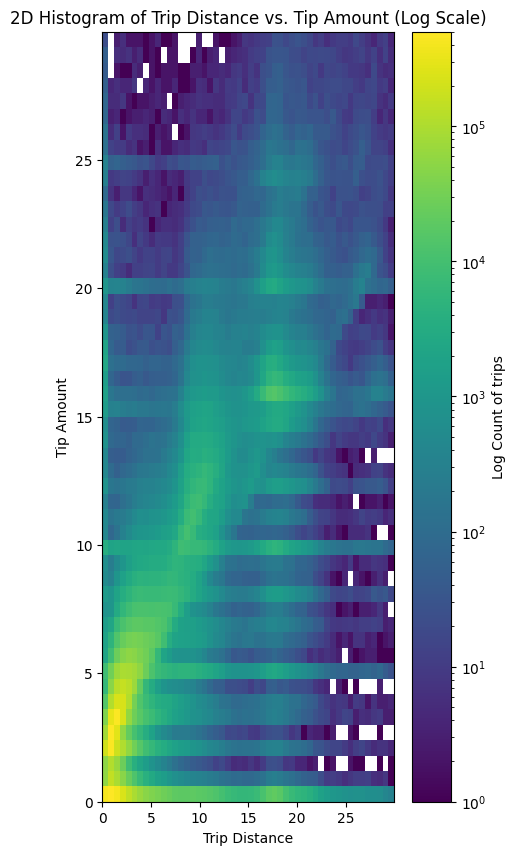

In [ ]:
from matplotlib.colors import LogNorm

plt.subplot(1, 3, 2)
plt.hist2d(df_train.query('trip_distance < 30 & tip_amount < 30')['trip_distance'],
           df_train.query('trip_distance < 30 & tip_amount < 30')['tip_amount'],
           bins=(50, 50), cmap='viridis', norm=LogNorm())
plt.xlabel('Trip Distance')
plt.ylabel('Tip Amount')
plt.title('2D Histogram of Trip Distance vs. Tip Amount (Log Scale)')
plt.colorbar(label='Log Count of trips')

## 3) Comparison of tips in popular areas

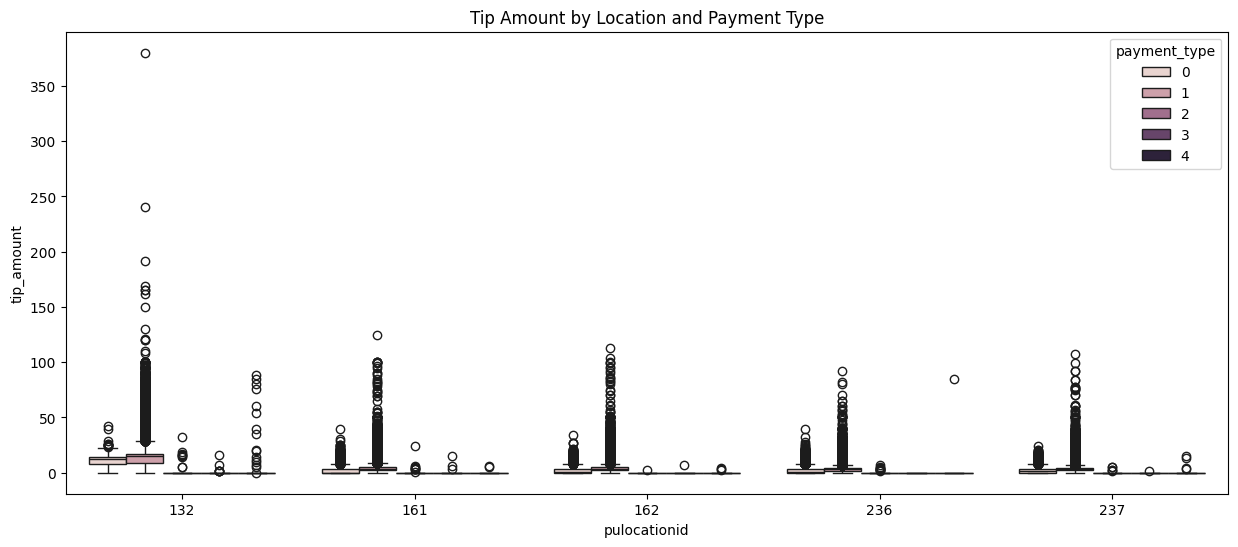

In [ ]:
# Choose the top 5 popular areas
top5_locations = df_train['pulocationid'].value_counts().nlargest(5).index

plt.figure(figsize=(15, 6))
sns.boxplot(x='pulocationid', y='tip_amount', hue='payment_type',
            data=df_train[df_train['pulocationid'].isin(top5_locations)])
plt.title('Tip Amount by Location and Payment Type')
plt.show()


## 4) Time and Tip Analysis


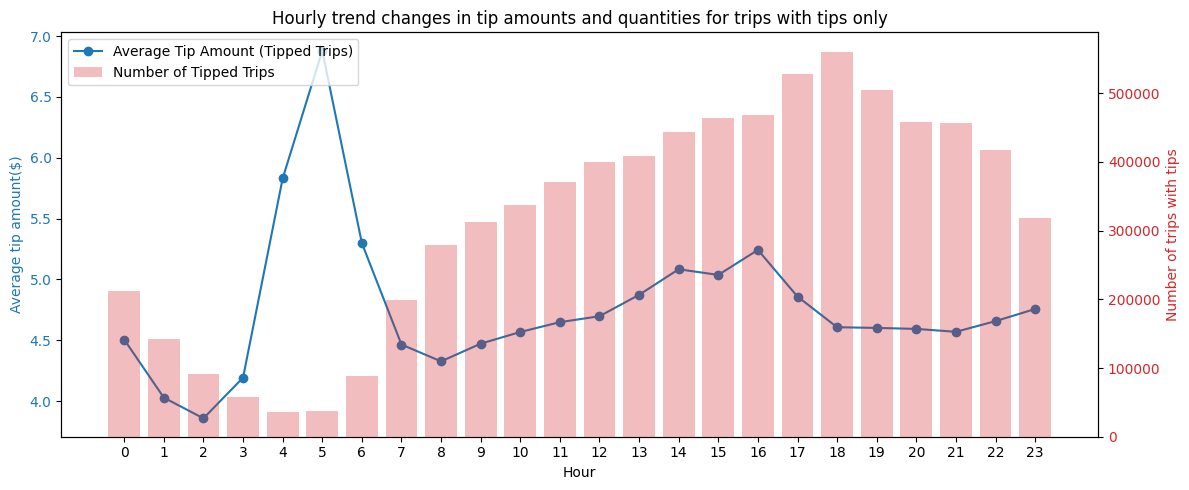


工作日 vs 周末小费差异检验:
MannwhitneyuResult(statistic=np.float64(10343589686895.5), pvalue=np.float64(0.0))
工作日平均小费: 3.6984478368784983
周末平均小费: 3.4494015651301204


In [ ]:
from scipy import stats

df_train['tpep_pickup_datetime'] = pd.to_datetime(df_train['tpep_pickup_datetime'])
df_train['hour'] = df_train['tpep_pickup_datetime'].dt.hour
df_train['weekday'] = df_train['tpep_pickup_datetime'].dt.dayofweek < 5  # True=工作日

# Time trend analysis
df_tipped = df_train[df_train['tip_amount'] > 0].copy()
df_tipped['tpep_pickup_datetime'] = pd.to_datetime(df_tipped['tpep_pickup_datetime'])
df_tipped['hour'] = df_tipped['tpep_pickup_datetime'].dt.hour
average_tip_per_hour_tipped = df_tipped.groupby('hour')['tip_amount'].mean()
trip_counts_per_hour_tipped = df_tipped.groupby('hour').size()

plt.figure(figsize=(12,5))
ax1 = average_tip_per_hour_tipped.plot(kind='line', marker='o', color='tab:blue', label='Average Tip Amount (Tipped Trips)')
ax1.set_title('Hourly trend changes in tip amounts and quantities for trips with tips only')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Average tip amount($)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(range(0,24))

ax2 = ax1.twinx()
ax2.bar(trip_counts_per_hour_tipped.index, trip_counts_per_hour_tipped.values, alpha=0.3, color='tab:red', label='Number of Tipped Trips')
ax2.set_ylabel('Number of trips with tips', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(axis='x', alpha=0.5)
plt.tight_layout()
plt.show()

# Weekday/weekend
weekday_tips = df_train[df_train['weekday']]['tip_amount']
weekend_tips = df_train[~df_train['weekday']]['tip_amount']
print("\n工作日 vs 周末小费差异检验:")
print(stats.mannwhitneyu(weekday_tips, weekend_tips))
print("工作日平均小费:", df_train[df_train['weekday']]['tip_amount'].mean())
print("周末平均小费:", df_train[~df_train['weekday']]['tip_amount'].mean())